In [1]:
%load_ext autoreload
%autoreload 2

# Intro to 4D-STEM data: calibration

There are many calibrations that can be performed on 4DSTEM data.  Which ones are necessary depends on the data and the analysis being performed.  The most typical calibrations are

- the origin
- the ellipticity
- the pixel size

In this notebook we'll perform these three calibration.

There are various methods for performing calibrations.  Here we'll calibrate using the Bragg vectors detected in the previous notebook.


### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Colin Ophus (clophus@lbl.gov)


Updated 11/3/2022

## Set up the environment

In [1]:
import py4DSTEM
from py4DSTEM.visualize import show
py4DSTEM.__version__

'0.14.0'

In [2]:
py4DSTEM.check_config()

Checking Module Dependencies
 All Dependencies for Base are Installed 
 Not All Dependencies for Ipyparallel are Installed
 Not All Dependencies for Cuda are Installed
 Not All Dependencies for Acom are Installed
 Not All Dependencies for Aiml are Installed
 Not All Dependencies for Aiml-cuda are Installed
 Not All Dependencies for Numba are Installed


---
# Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (501 megabytes)
* [Simulated single crystal and polycrystalline gold](https://drive.google.com/file/d/1PmbCYosA1eYydWmmZebvf6uon9k_5g_S/view?usp=sharing)

# Load data

Load the same datacube as in the previous notebook, and additionally, load all the results produced in that notebook.

In [3]:
# Set the filepath

from os.path import splitext

filepath_data = "/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/data_binned.h5"
filepath_basics_02 = splitext(filepath_data)[0] + '_analysis_basics_02.h5'

In [4]:
# Load the datacube

datacube = py4DSTEM.read(
    filepath_data,
    data_id = 'polyAu_4DSTEM'
)

datacube

DataCube( A 4-dimensional array of shape (100, 84, 125, 125) called 'polyAu_4DSTEM',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [5]:
# Load the prior analysis

basics_02 = py4DSTEM.read(
    filepath_basics_02
)

basics_02.tree()

Reading PointListArray: 100%|███████████████████████████████████| 8400/8400 [00:01<00:00, 4684.35PointList/s]


/
|---braggvectors
|---probe


# Examine the Bragg vectors

In [6]:
# let's assign the bragg vectors a variable for convenience

braggpeaks = basics_02.tree('braggvectors')

braggpeaks

BraggVectors( A (100, 84)-shaped array of lists of bragg vectors )

In [7]:
# Data can be retrieved from BraggVectors instances in two places: .raw, and .cal
# Let's look at .raw first:

braggpeaks.raw

RawVectorGetter( Retrieves raw bragg vectors. Get vectors for scan position x,y with [x,y]. )

In [8]:
braggpeaks.raw[0,0]

BVects( A set of 8 bragg vectors. Access data with .qx, .qy, .I, or .data.)

In [9]:
print(braggpeaks.raw[0,0].qx)
print()
print(braggpeaks.raw[0,0].qy)
print()
print(braggpeaks.raw[0,0].I)

[ 63.51548654  82.03406218 116.4613866   45.58509191  67.32635496
  81.4272291   35.36481917  17.6981705 ]

[ 63.9274206   47.58656296  81.02575286  80.03388888 107.43030654
  78.88045181  39.38512343  18.85337312]

[1441.57319378   32.21533325   30.75836161   30.31446468   21.56665065
   14.03542371    8.84041866    8.28413216]


In [10]:
# The .data property gives us everything (positions and intensities) in a single numpy array.
# It's a structured array, meaning it has a 'dtype' containing several fields,
# each with their own datatype

braggpeaks.raw[0,0].data

array([( 63.51548654,  63.9274206 , 1441.57319378),
       ( 82.03406218,  47.58656296,   32.21533325),
       (116.4613866 ,  81.02575286,   30.75836161),
       ( 45.58509191,  80.03388888,   30.31446468),
       ( 67.32635496, 107.43030654,   21.56665065),
       ( 81.4272291 ,  78.88045181,   14.03542371),
       ( 35.36481917,  39.38512343,    8.84041866),
       ( 17.6981705 ,  18.85337312,    8.28413216)],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [11]:
braggpeaks.raw[0,0].data['qx']

array([ 63.51548654,  82.03406218, 116.4613866 ,  45.58509191,
        67.32635496,  81.4272291 ,  35.36481917,  17.6981705 ])

In [12]:
# The calibrated vectors at .cal have the same interface
# The only difference is that these vectors are transformed before
# being returned, with the transformation that is applied determined
# by the BraggVector's calibration state

# The initial calibration state has no calibrations applied, so
# is identical to the raw vectors

braggpeaks.cal[0,0].data

array([( 63.51548654,  63.9274206 , 1441.57319378),
       ( 82.03406218,  47.58656296,   32.21533325),
       (116.4613866 ,  81.02575286,   30.75836161),
       ( 45.58509191,  80.03388888,   30.31446468),
       ( 67.32635496, 107.43030654,   21.56665065),
       ( 81.4272291 ,  78.88045181,   14.03542371),
       ( 35.36481917,  39.38512343,    8.84041866),
       ( 17.6981705 ,  18.85337312,    8.28413216)],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [13]:
# You can check the current calibration state

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': False, 'rotate': False}

In [14]:
# The calibrations state can be set by calling the .setcal method
# If no arguments are supplied, the calibrations to apply are set based
# on what's available in the dataset's Calibration metadata (at .calibation)

braggpeaks.setcal()

In [15]:
# All the calibrations are still set to False because we haven't performed
# any calibration measurements yet

braggpeaks.calstate

{'center': False, 'ellipse': False, 'pixel': False, 'rotate': False}

In [16]:
# This is reflected in the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
)

In [17]:
# If we try to set the braggvector's calibration state to perform a transformation
# for which is can't find the needed measurement in the Calibration metadata, it
# raises an error

braggpeaks.setcal(
    center = True,       # This can't be True without first setting the origin position!
    ellipse = False,
    pixel = False,
    rotate = False
)

AssertionError: Requested calibration not found

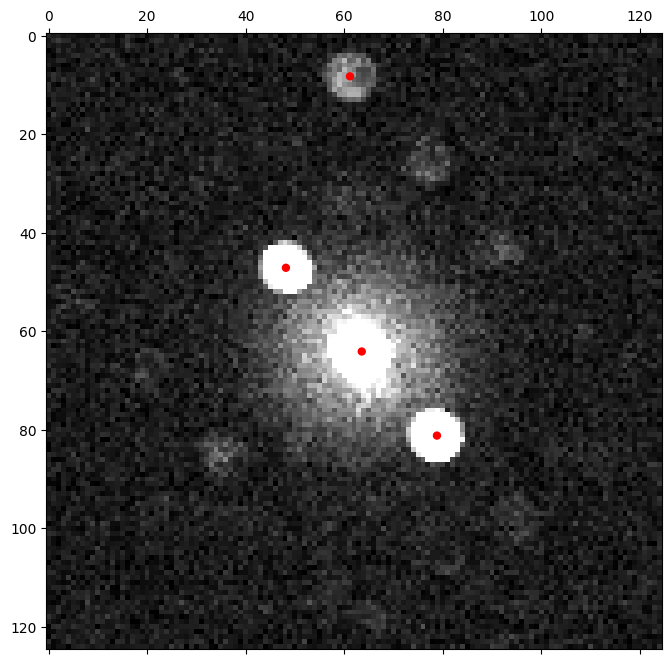

In [18]:
# Let's confirm that these represent the positions of detected bragg disks
# in the diffraction pattern at scan position (10,20)

dp = datacube[10,20]
v = braggpeaks.raw[10,20]

show(
    dp,
    points = {
        'x' : v.qx,
        'y' : v.qy,
    }
)

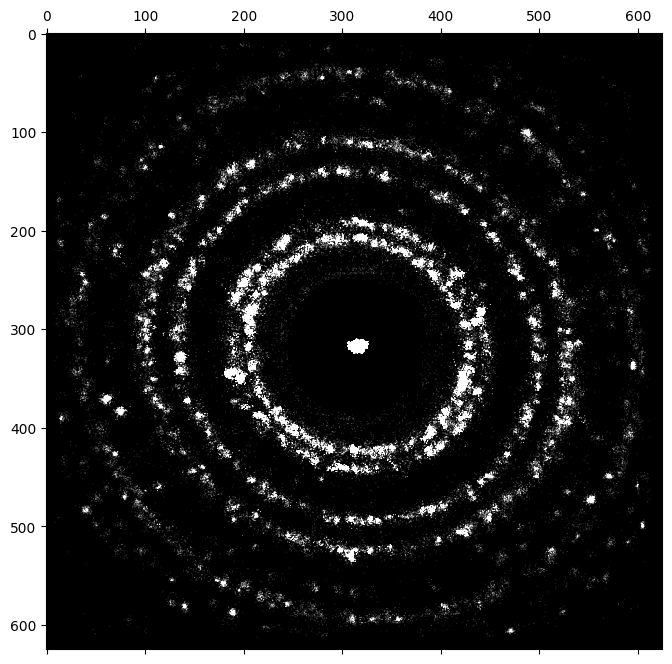

In [19]:
# compute the bragg vector map

bvm = braggpeaks.histogram(
    mode='raw',
    sampling = 0.2,
)

show(bvm)

In [20]:
bvm

Array( A 2-dimensional array of shape (625, 625) called '2Dhist_braggvectors_raw_s=0.2',
       with dimensions:

       dim0 = [0.0,0.2,...] pixels
       dim1 = [0.0,0.2,...] pixels
)

In [21]:
bvm.dims

(array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
          1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
          3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
          5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
          7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
          9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
         10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
         12.6,  12.8,  13. ,  13.2,  13.4,  13.6,  13.8,  14. ,  14.2,
         14.4,  14.6,  14.8,  15. ,  15.2,  15.4,  15.6,  15.8,  16. ,
         16.2,  16.4,  16.6,  16.8,  17. ,  17.2,  17.4,  17.6,  17.8,
         18. ,  18.2,  18.4,  18.6,  18.8,  19. ,  19.2,  19.4,  19.6,
         19.8,  20. ,  20.2,  20.4,  20.6,  20.8,  21. ,  21.2,  21.4,
         21.6,  21.8,  22. ,  22.2,  22.4,  22.6,  22.8,  23. ,  23.2,
         23.4,  23.6,  23.8,  24. ,  24.2,  24.4,  24.6,  24.8,  25. ,
      

# Calibrate the origin

We'll calibrate the origin in three steps:

- measure the origin position using the brightest disk from the disk detection
- fit a plane to those measurements
- apply the calibrations to the Bragg vectors

In [22]:
# Measure the origin

qx0_meas,qy0_meas,mask_meas = braggpeaks.measure_origin()

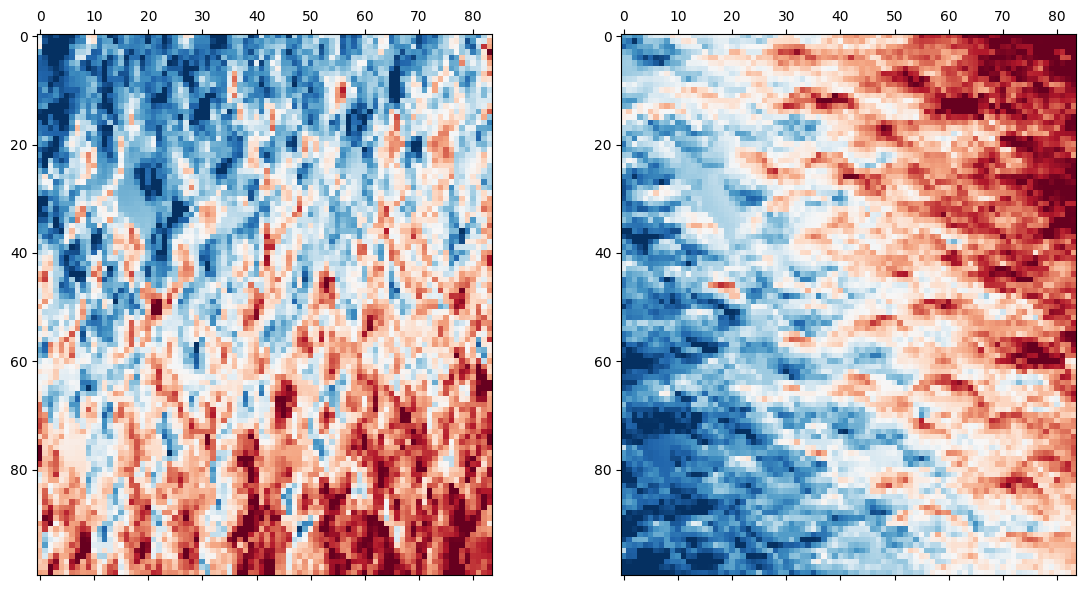

In [23]:
# Show

show(
    [qx0_meas,qy0_meas],
    cmap = 'RdBu',
    mask = mask_meas
)

In [24]:
# Note that braggpeaks.measure_origin added its results to the Calibration metadata

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             qx0_meas:        2D-array
             qy0_meas:        2D-array
)

In [25]:
braggpeaks.calibration.get_origin()

In [26]:
# Here's how to retrieve the data:

braggpeaks.calibration.get_origin_meas()

(array([[63.51548654, 64.19776396, 64.86282732, ..., 63.98964664,
         63.66152767, 63.34431954],
        [63.42879823, 64.14519955, 64.3780199 , ..., 63.50366921,
         63.55208392, 63.1199585 ],
        [63.35366221, 64.34438362, 64.73597022, ..., 63.63418986,
         62.79330118, 63.07235426],
        ...,
        [63.19720851, 63.1458715 , 62.84209889, ..., 62.77270342,
         62.90932073, 62.78616605],
        [63.17163546, 63.16777313, 62.49541276, ..., 62.81172616,
         62.89472538, 62.68714218],
        [63.06401357, 63.08110571, 62.5062978 , ..., 63.02098066,
         62.80180769, 62.75193991]]),
 array([[63.9274206 , 63.86769584, 63.9957896 , ..., 61.54918628,
         61.57989396, 61.51093205],
        [64.04731885, 64.16938774, 64.47895689, ..., 61.0801701 ,
         61.82473324, 61.86445326],
        [64.26343663, 64.06172053, 64.01144938, ..., 61.58026459,
         61.17232114, 61.70991362],
        ...,
        [64.70191738, 64.47052206, 64.8684884 , ..., 6

In [27]:
# These arrays are identical to the ones we just found

print( braggpeaks.calibration.get_origin_meas()[0] is qx0_meas )
print( braggpeaks.calibration.get_origin_meas()[1] is qy0_meas )

True
True


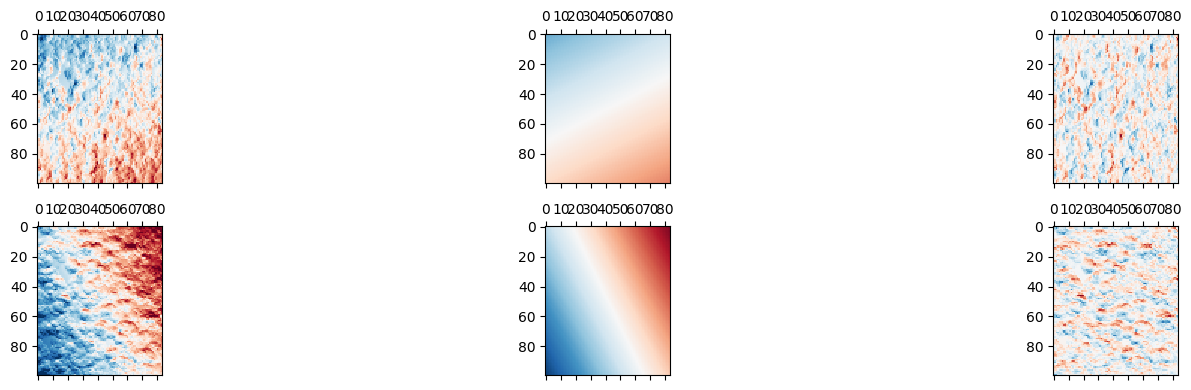

In [28]:
# Fit a plane to the origins

qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = braggpeaks.fit_origin()

In [29]:
# The fit origins now live in the calibration metadata as 'qx0','qy0'

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             qx0_meas:        2D-array
             qy0_meas:        2D-array
             qx0:             2D-array
             qx0_mean:        63.41782471755659
             qx0_shift:       2D-array
             qy0:             2D-array
             qy0_mean:        63.2504418142827
             qy0_shift:       2D-array
)

In [30]:
# we should now be able to center calibrate the Bragg vectors

braggpeaks.setcal()
braggpeaks.calstate

{'center': True, 'ellipse': False, 'pixel': False, 'rotate': False}

In [31]:
braggpeaks.cal[0,0].data

array([( -0.63192323,   0.29941793, 1441.57319378),
       ( 17.88665241, -16.04143971,   32.21533325),
       ( 52.31397683,  17.39775019,   30.75836161),
       (-18.56231786,  16.40588621,   30.31446468),
       (  3.17894519,  43.80230387,   21.56665065),
       ( 17.27981933,  15.25244914,   14.03542371),
       (-28.7825906 , -24.24287924,    8.84041866),
       (-46.44923927, -44.77462955,    8.28413216)],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

In [32]:
braggpeaks.raw[0,0].data

array([( 63.51548654,  63.9274206 , 1441.57319378),
       ( 82.03406218,  47.58656296,   32.21533325),
       (116.4613866 ,  81.02575286,   30.75836161),
       ( 45.58509191,  80.03388888,   30.31446468),
       ( 67.32635496, 107.43030654,   21.56665065),
       ( 81.4272291 ,  78.88045181,   14.03542371),
       ( 35.36481917,  39.38512343,    8.84041866),
       ( 17.6981705 ,  18.85337312,    8.28413216)],
      dtype=[('qx', '<f8'), ('qy', '<f8'), ('intensity', '<f8')])

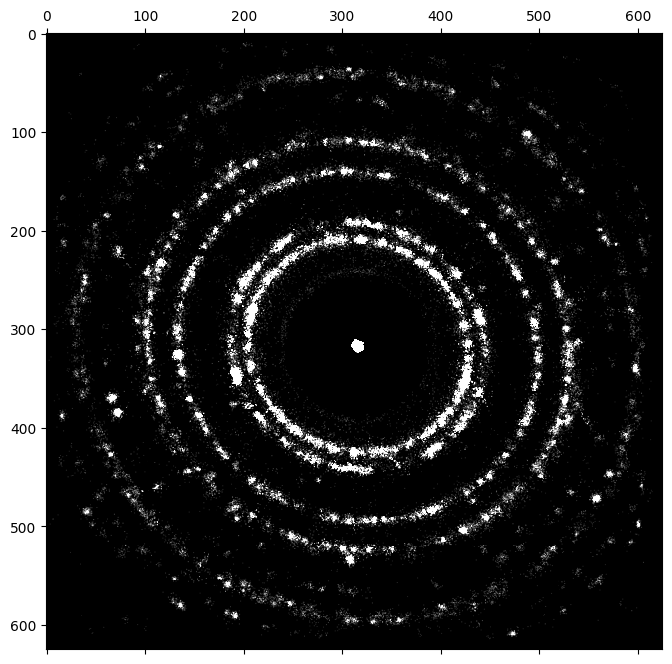

In [33]:
# compute the bragg vector map

bvm = braggpeaks.histogram(
    #mode='raw',
    mode='cal',
    sampling = 0.2,
)

show(bvm)#,vmax=0.9)

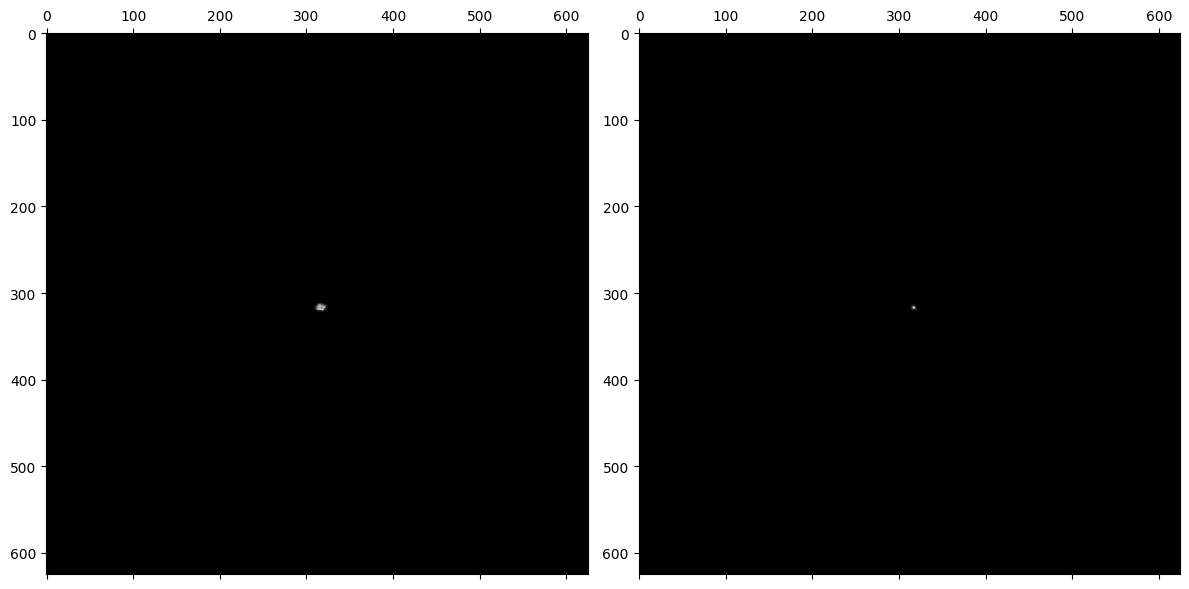

In [34]:
# Compare this to the uncalibrated BVM - much better!

s = 0.2
bvm_r = braggpeaks.histogram( mode='raw', sampling=s )
bvm_c = braggpeaks.histogram( mode='cal', sampling=s )


show( [bvm_r, bvm_c] ,vmax=0.999999)

# Calibrate the ellipticity

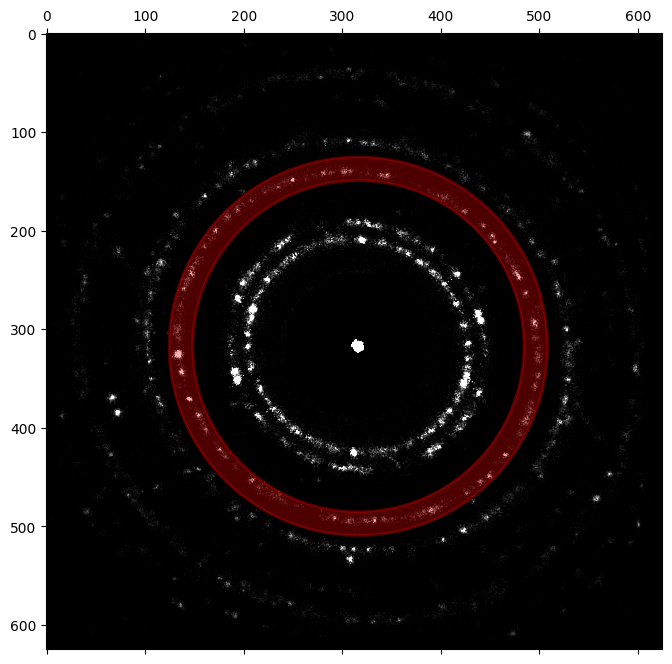

In [35]:
# Select an annular region in which to perform a fit
# The ideal is a single, isolated ring of peaks

q_range = (168, 192)

center_resamp = tuple([x/s for x in braggpeaks.calibration.get_origin_mean()])

py4DSTEM.show(
    bvm_c,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=3e2,
    annulus={
        'center':center_resamp,
        'radii': q_range,'fill':True,'color':'r','alpha':0.3}
)

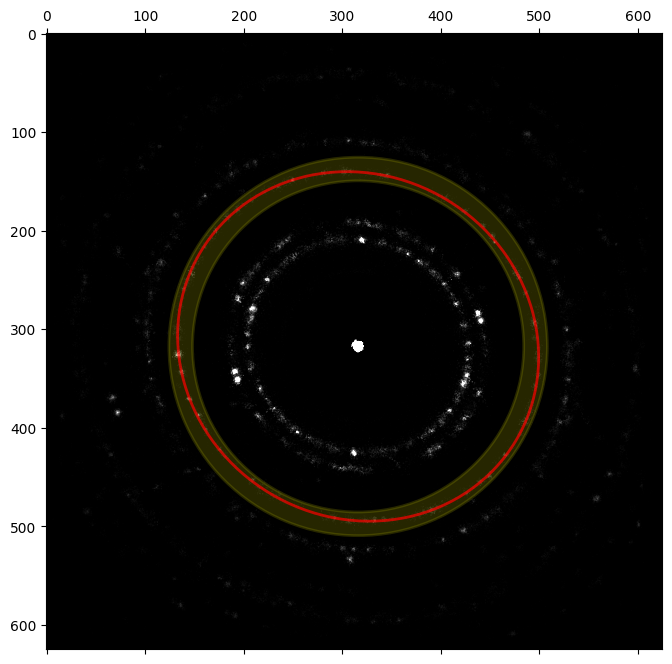

In [36]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_c,
    center = center_resamp,
    fitradii = q_range,
)

# plot the fit
py4DSTEM.visualize.show_elliptical_fit(
    bvm_c,
    q_range,
    p_ellipse,
    cmap='gray',
    intensity_range='absolute',
    vmin=0,
    vmax=1e3,
)

In [37]:
p_ellipse

(317.36029070663994,
 316.0909265164872,
 186.4261221954971,
 173.85528849696885,
 -2.1140541735005085)

In [38]:
# The elliptical parameters are not automatically added to the calibration metadata, so
# need to be added manually once a good fit is found, like so:

braggpeaks.calibration.set_p_ellipse(p_ellipse)

In [39]:
# Note that the code above only adds (a,b,theta) to the calibration metadata; the origin needs to
# be calibrated separately, as we did above 

braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             qx0_meas:        2D-array
             qy0_meas:        2D-array
             qx0:             2D-array
             qx0_mean:        63.41782471755659
             qx0_shift:       2D-array
             qy0:             2D-array
             qy0_mean:        63.2504418142827
             qy0_shift:       2D-array
             a:               186.4261221954971
             b:               173.85528849696885
             theta:           -2.1140541735005085
)

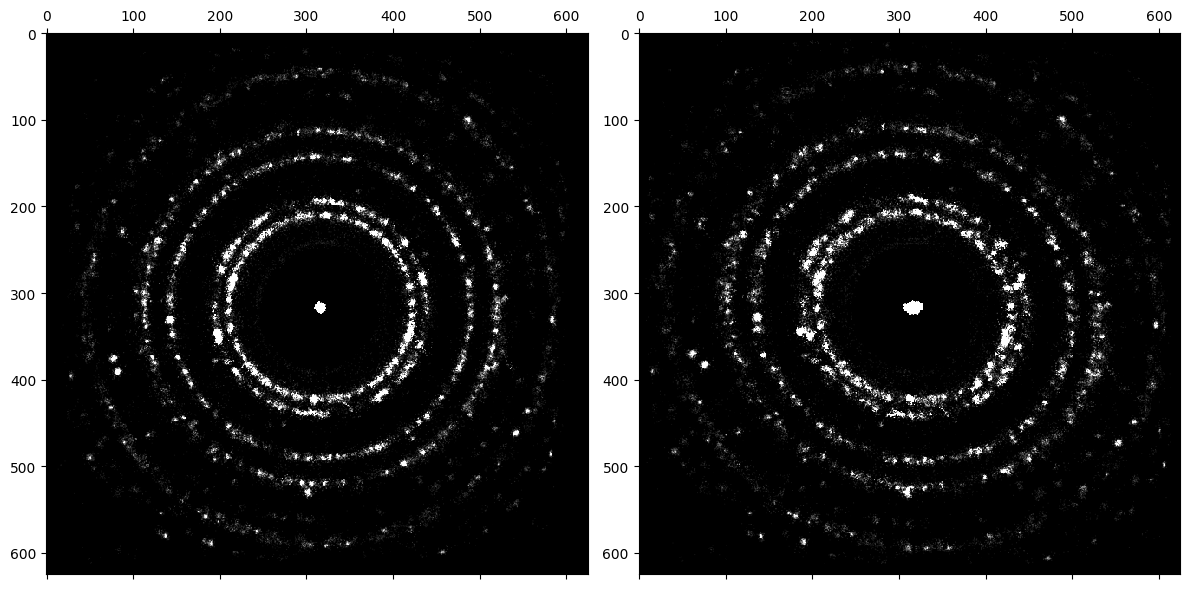

In [40]:
# Calibrate, compute a new bragg vector map, and compare

braggpeaks.setcal()
bvm_e = braggpeaks.histogram(
    sampling=s
)

show([bvm_e, bvm_r],vmax=0.99)

# Calibrate the detector pixel size

The pixel size should be calibrated from a known standard.  In this case, our data is of Au nanoparticles, so we can use the scattering from the data itself for calibration.  For experiments examining samples of unknown structure, it is best practice is to record a separate scan of a standard sample, such as Au nanoparticles, for each set of microscope conditions used.  Calibration scans should be performed during the same session as the experimental scans.

For data that requires elliptical calibrations, the pixel size should be calibrated last, as prior calibrations like ellipticity will influence the pixel size.  Before calibrating and correcting the ellipticity, the true pixel size was effectively variable by position and direction in diffraction space!

Below, we calibrate the pixel size by computing the structure factors of gold, and matching them to our detected bragg scattering

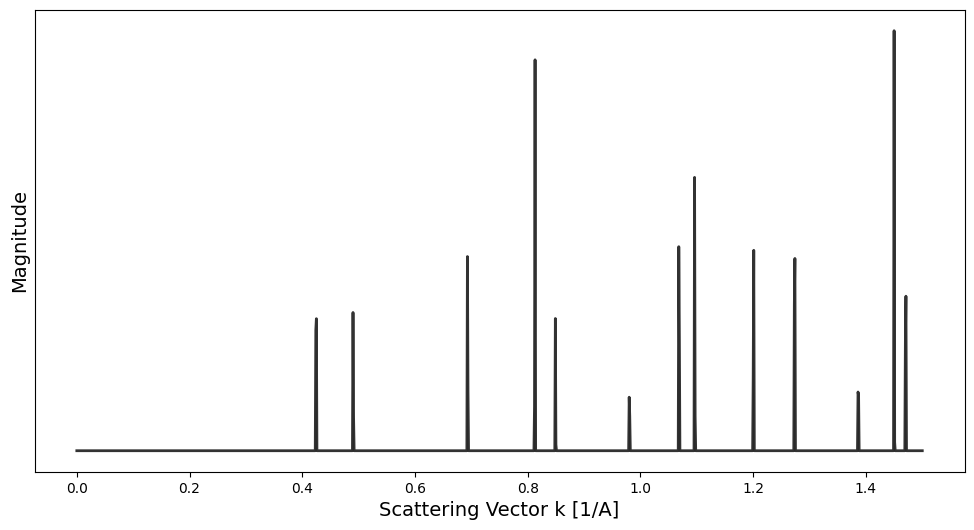

In [41]:
# Define gold structure 


# set lattice parameter and Z-number
a_lat = 4.08
atom_num = 79

# set max scattering angle, in inverse Angstroms
k_max = 1.5


# Define lattice
import numpy as np
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])

# Make crystal
crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    a_lat)

# Calculate structure factors
crystal.calculate_structure_factors(k_max)

# Show
crystal.plot_scattering_intensity()

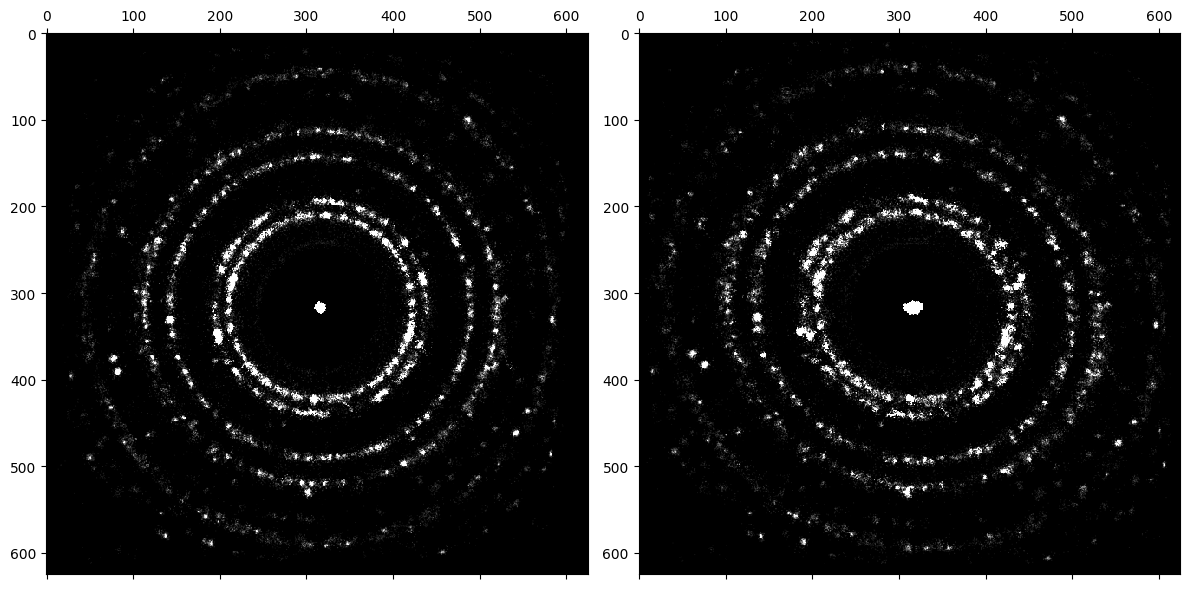

In [42]:
# Make an initial guess at the pixel size to refine
# Let's estimate eith an overlay of the measured scattering and reference crystal structure


# set pixel size
pixel_size_inv_Ang_guess = 0.02


# New bvm, compare

braggpeaks.setcal()
bvm_p = braggpeaks.histogram(
    sampling=s
)

show([bvm_p, bvm_r],vmax=0.99)

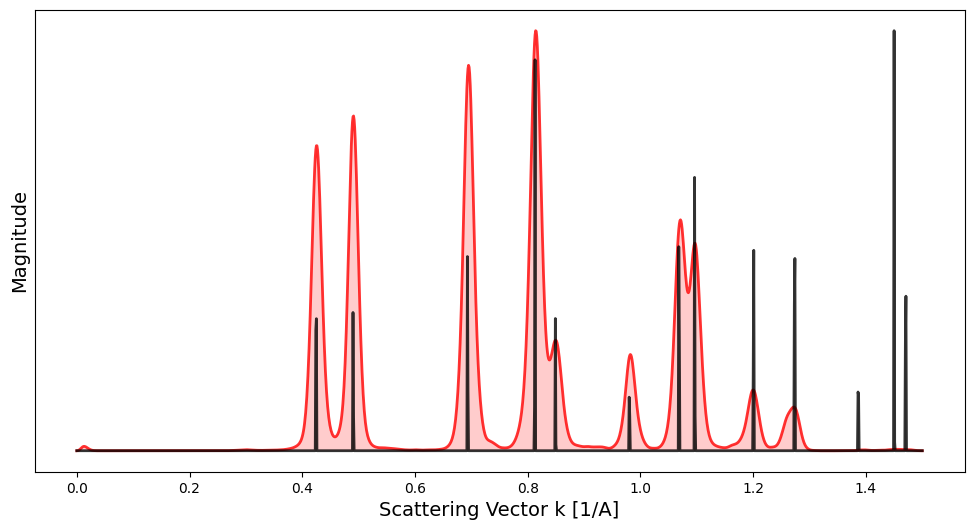

In [43]:
# Make an initial guess at the pixel size to refine
# Let's estimate eith an overlay of the measured scattering and reference crystal structure


# set pixel size
pixel_size_inv_Ang_guess = 0.02

# calibrate
braggpeaks.calibration.set_Q_pixel_size(pixel_size_inv_Ang_guess)
braggpeaks.calibration.set_Q_pixel_units('A^-1')
braggpeaks.setcal()

# show overlay
crystal.plot_scattering_intensity(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0
)

Calibrated pixel size = 0.01996456 A^-1


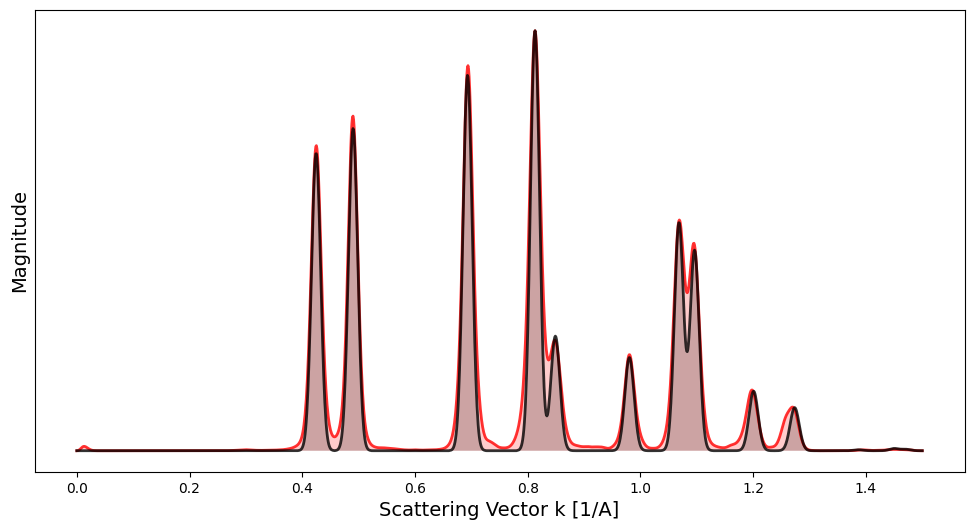

In [44]:
# fit pixel size to lattice

crystal.calibrate_pixel_size(
    bragg_peaks = braggpeaks,
    bragg_k_power = 2.0,
    plot_result = True,
);

In [45]:
braggpeaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.019964564107539093
             R_pixel_size:    1
             Q_pixel_units:   A^-1
             R_pixel_units:   pixels
             qx0_meas:        2D-array
             qy0_meas:        2D-array
             qx0:             2D-array
             qx0_mean:        63.41782471755659
             qx0_shift:       2D-array
             qy0:             2D-array
             qy0_mean:        63.2504418142827
             qy0_shift:       2D-array
             a:               186.4261221954971
             b:               173.85528849696885
             theta:           -2.1140541735005085
)

# Write and read

In [46]:
# set a filepath

filepath = splitext(filepath_data)[0] + '_analysis_basics_03.h5'
filepath

'/Users/Ben/work/data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/data_binned_analysis_basics_03.h5'

In [47]:
# inspect what's in the data tree

basics_02.tree()

/
|---braggvectors
|---probe


In [48]:
# we can see above that the bragg vector map doesn't get added automatically to the tree.
# just for fun, let's do that now:

basics_02.tree(
    bvm_p
)

basics_02.tree()

/
|---braggvectors
|---probe
|---2Dhist_braggvectors_cal_s=0.2


In [49]:
# save

py4DSTEM.save(
    filepath,
    basics_02,
    tree=None,
    mode = 'o'
)

100%|██████████████████████████████████████████████████████████████████| 8400/8400 [00:01<00:00, 4471.25it/s]


In [50]:
# inspect the resulting HDF5 file

py4DSTEM.print_h5_tree(filepath)

/
|---polyAu_4DSTEM
    |---2Dhist_braggvectors_cal_s=0.2
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [51]:
# read

d = py4DSTEM.read(
    filepath,
)

Reading PointListArray: 100%|███████████████████████████████████| 8400/8400 [00:01<00:00, 4426.78PointList/s]


In [52]:
d.tree()

/
|---2Dhist_braggvectors_cal_s=0.2
|---braggvectors
|---probe


In [53]:
d.tree('braggvectors')

BraggVectors( A (100, 84)-shaped array of lists of bragg vectors )

In [54]:
d.tree('braggvectors').calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.019964564107539093
             R_pixel_size:    1
             Q_pixel_units:   A^-1
             R_pixel_units:   pixels
             a:               186.4261221954971
             b:               173.85528849696885
             qx0:             2D-array
             qx0_mean:        63.41782471755659
             qx0_meas:        2D-array
             qx0_shift:       2D-array
             qy0:             2D-array
             qy0_mean:        63.2504418142827
             qy0_meas:        2D-array
             qy0_shift:       2D-array
             theta:           -2.1140541735005085
)

In [55]:
py4DSTEM.print_h5_tree(filepath)

/
|---polyAu_4DSTEM
    |---2Dhist_braggvectors_cal_s=0.2
    |---braggvectors
    |   |---_v_uncal
    |---probe




In [56]:
bv = py4DSTEM.read(
    filepath,
    datapath = 'polyAu_4DSTEM/braggvectors'
)

Reading PointListArray: 100%|███████████████████████████████████| 8400/8400 [00:01<00:00, 4482.88PointList/s]


In [57]:
bv

BraggVectors( A (100, 84)-shaped array of lists of bragg vectors )

In [58]:
bv.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.019964564107539093
             R_pixel_size:    1
             Q_pixel_units:   A^-1
             R_pixel_units:   pixels
             a:               186.4261221954971
             b:               173.85528849696885
             qx0:             2D-array
             qx0_mean:        63.41782471755659
             qx0_meas:        2D-array
             qx0_shift:       2D-array
             qy0:             2D-array
             qy0_mean:        63.2504418142827
             qy0_meas:        2D-array
             qy0_shift:       2D-array
             theta:           -2.1140541735005085
)